# Predict volume from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.model.ensemble import *
from enveco.metrics import *

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Run the example workflow for predicting the volume of the field plot from LiDAR-derived features.

# Read and preprocess data

In [3]:
#data_path = Path('../../../andras/ml/AV_leafon/')
data_path = Path('../../enveco_data/enveco/')

preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features
* point_features
* intensity_features
* height_quantiles
* point_proportions
* canopy_densities

Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [4]:
def tree_pcts(row):
    return [row.v_ma/row.v, row.v_ku/row.v, row.v_lp/row.v]

In [5]:
preprocessor.train_val_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = preprocessor.train_val_df.apply(lambda row: tree_pcts(row), 
                                                                                                  axis=1, result_type='expand')

In [6]:
preprocessor.test_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = preprocessor.test_df.apply(lambda row: tree_pcts(row), 
                                                                                                  axis=1, result_type='expand')

In [7]:
preprocessor.train_val_df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,...,a_date_1,a_window_1,filename_2,a_date_2,a_window_2,v_lp_proc,is_valid,rel_v_ma,rel_v_ku,rel_v_lp
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,...,2013-07-11,C,NaN,NaN,NaN,77,0,0.148862,0.082378,0.768760
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,...,2013-07-11,C,NaN,NaN,NaN,2,0,0.976027,0.000000,0.023973
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,...,2013-07-11,C,NaN,NaN,NaN,8,0,0.581760,0.340057,0.078142
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,...,2013-07-11,C,NaN,NaN,NaN,24,0,0.224408,0.536431,0.239161
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,...,2013-07-11,C,NaN,NaN,NaN,0,0,0.855440,0.144560,0.000000


In [39]:
trainval_tb, test_tb = preprocessor.preprocess_lidar(target_col=['h'], path=data_path/'AV_las',
                                                     mask_plot=False,
                                                     min_h=1.3,
                                                     normalize=True,
                                                     log_y=False)

100%|██████████| 225/225 [00:05<00:00, 43.08it/s]


Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [40]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock)

Check the distribution of the target variable `v`, in order to get limits for `sigmoid_range`.

In [13]:
trainval_tb.train.y.describe()

count    1044.000000
mean      145.712250
std        86.097336
min         2.700000
25%        80.927498
50%       132.125000
75%       191.305000
max       867.349976
Name: v, dtype: float64

In [14]:
trainval_tb.valid.y.describe()

count    225.000000
mean     150.768631
std       95.610825
min        2.310000
25%       87.419998
50%      133.600006
75%      191.639999
max      539.479980
Name: v, dtype: float64

In [15]:
test_tb.train.y.describe()

count    225.000000
mean     152.013641
std       97.223846
min        7.000000
25%       87.820000
50%      134.979996
75%      192.529999
max      550.169983
Name: v, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 1000 m³ as the maximum value for the total volume.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [16]:
learn = tabular_learner(dls, 
                        metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  
                        y_range=(0, trainval_tb.train.y.max()*1.1)
                       )
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 59'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 59              118        True      
________________________________________________________________
BatchNorm1d          64 x 59              118        True      
________________________________________________________________
Linear               64 x 200             11,800     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

Find learning rate to use.

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.001737800776027143)

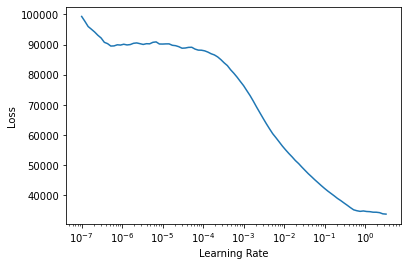

In [17]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,83163.867188,79875.398438,282.622345,187.454346,266.828003,176.978470,269.641907,-7.776742,00:00
1,73485.562500,58322.476562,241.500473,160.179520,227.488800,150.886032,230.765900,-5.408499,00:00
2,61274.839844,34868.156250,186.730164,123.852135,168.955551,112.062798,173.910538,-2.831328,00:00
3,47607.972656,15530.276367,124.620522,82.656792,95.181175,63.130619,108.217690,-0.706473,00:00
4,34795.828125,6269.778809,79.181938,52.518837,38.872688,25.783009,63.193012,0.311074,00:00
5,24919.199219,2956.159668,54.370579,36.062260,11.728776,7.779321,40.488091,0.675176,00:00
6,18007.904297,2199.264648,46.896317,31.104824,5.176603,3.433475,32.480850,0.758344,00:00
7,13219.751953,1970.199219,44.386925,29.440424,1.171235,0.776843,29.965872,0.783514,00:00
8,9860.989258,1795.442627,42.372665,28.104431,5.596266,3.711824,28.697536,0.802716,00:00
9,7526.133789,1710.534180,41.358604,27.431837,4.699718,3.117173,27.643351,0.812046,00:00


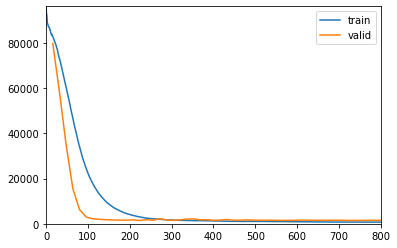

In [18]:
learn.fit_one_cycle(50, max_lr=1e-2, cbs=ShowGraphCallback())

See validation results

In [19]:
learn.validate()

(#7) [1535.4110107421875,39.18431854248047,25.989702224731445,4.95020866394043,3.2833147048950195,26.708513259887695,0.8312883994204828]

In [20]:
preds, true = learn.get_preds()

`RegressionInterpretation` can be used to plot results.

In [21]:
reg_interp = RegressionInterpretation.from_learner(learn)

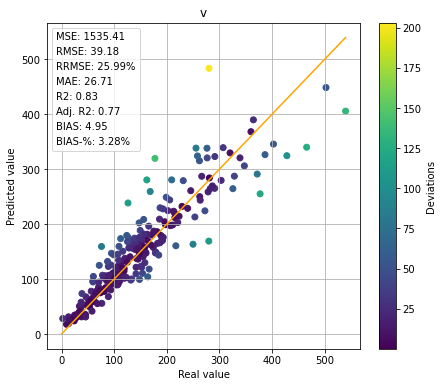

In [22]:
reg_interp.plot_results(log_y=False)
plt.show()

Evaluate test set.

In [ ]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [24]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

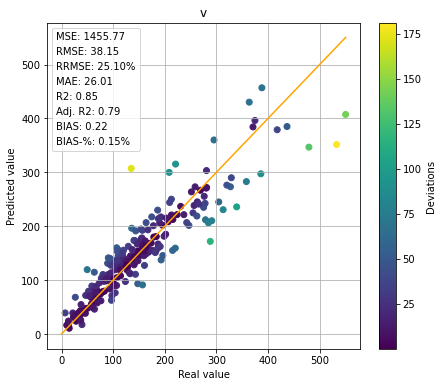

In [25]:
test_interp.plot_results(log_y=False)
plt.show()

In [23]:
test_preds = learn.get_preds(dl=test_dls.train)

# Ensemble of ANNs

Fit several models at once.

In [41]:
ensemble = Ensemble(dls, learn_func=tabular_learner, ens_dir='ensemble_h_no_intensity',
                    y_range=(0,trainval_tb.y.max() * 1.1), 
                    metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], 
                    n_models=10)

In [42]:
ensemble.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,10.022571,9.068676,3.011424,20.152594,0.616755,4.127354,2.337998,0.542984,00:00
1,6.215637,2.482745,1.575673,10.544478,0.340849,2.280977,1.219259,0.874882,00:00
2,4.676091,2.037326,1.427349,9.551888,-0.047401,-0.317207,1.138367,0.897329,00:00
3,3.590506,1.562868,1.250147,8.366045,0.036563,0.244679,0.963671,0.921239,00:00
4,2.949543,1.389180,1.178635,7.887481,0.137322,0.918967,0.932148,0.929992,00:00
5,2.472343,1.360721,1.166499,7.806268,0.122112,0.817182,0.919961,0.931427,00:00
6,2.160101,1.485276,1.218719,8.155725,0.262875,1.759172,0.967022,0.925150,00:00
7,1.948814,1.480394,1.216715,8.142313,0.177983,1.191069,0.951970,0.925396,00:00
8,1.820472,1.459710,1.208184,8.085228,-0.212755,-1.423769,0.944397,0.926438,00:00
9,1.661624,1.419817,1.191561,7.973982,-0.227319,-1.521227,0.908812,0.928448,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,11.748987,7.584790,2.754050,18.430231,1.149206,7.690542,2.212934,0.617765,00:00
1,7.036112,2.107618,1.451764,9.715272,-0.191030,-1.278379,1.163543,0.893787,00:00
2,5.198084,1.692031,1.300781,8.704888,0.101987,0.682502,1.022446,0.914730,00:00
3,3.880416,1.367162,1.169257,7.824723,-0.016252,-0.108759,0.920247,0.931102,00:00
4,3.100688,1.528814,1.236452,8.274397,-0.165621,-1.108341,0.991319,0.922955,00:00
5,2.688320,1.588724,1.260446,8.434963,-0.260707,-1.744665,0.968851,0.919936,00:00
6,2.428309,1.383895,1.176391,7.872461,-0.127620,-0.854037,0.910408,0.930259,00:00
7,2.203749,1.708422,1.307066,8.746949,-0.019196,-0.128462,1.049036,0.913904,00:00
8,1.946496,1.330838,1.153620,7.720076,-0.018733,-0.125361,0.873950,0.932932,00:00
9,1.757730,1.416014,1.189964,7.963295,0.054038,0.361626,0.917293,0.928640,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,10.978930,9.141825,3.023545,20.233704,0.926803,6.202209,2.339531,0.539298,00:00
1,6.916312,2.324792,1.524727,10.203544,-0.068064,-0.455486,1.163188,0.882842,00:00
2,5.017158,1.852404,1.361031,9.108081,-0.182116,-1.218727,1.050953,0.906648,00:00
3,3.836273,1.659463,1.288202,8.620706,-0.243740,-1.631123,1.002622,0.916371,00:00
4,3.055149,1.445166,1.202151,8.044850,0.135151,0.904437,0.928261,0.927171,00:00
5,2.592162,1.679133,1.295814,8.671646,-0.256012,-1.713245,0.977835,0.915380,00:00
6,2.243141,1.475241,1.214595,8.128127,0.198546,1.328679,0.932853,0.925655,00:00
7,1.936503,1.374979,1.172595,7.847062,-0.106434,-0.712263,0.918497,0.930708,00:00
8,1.805057,1.595648,1.263189,8.453323,-0.272767,-1.825372,0.976708,0.919587,00:00
9,1.646939,1.607026,1.267685,8.483408,-0.190736,-1.276417,0.988619,0.919014,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,14.470800,11.874607,3.445955,23.060495,1.035979,6.932820,2.675472,0.401580,00:00
1,8.600313,2.052872,1.432785,9.588262,0.181901,1.217292,1.117872,0.896546,00:00
2,6.023297,1.704186,1.305445,8.736097,-0.198687,-1.329623,1.030148,0.914118,00:00
3,4.388626,1.524818,1.234835,8.263575,-0.278264,-1.862159,0.963254,0.923157,00:00
4,3.399801,1.390800,1.179322,7.892075,-0.039990,-0.267614,0.945396,0.929911,00:00
5,2.911954,1.444469,1.201861,8.042909,-0.290920,-1.946848,0.921998,0.927206,00:00
6,2.494073,1.364992,1.168329,7.818512,0.154570,1.034391,0.905790,0.931211,00:00
7,2.148475,1.357330,1.165045,7.796535,-0.333746,-2.233443,0.906034,0.931597,00:00
8,1.955501,1.377139,1.173516,7.853223,-0.244058,-1.633249,0.906897,0.930599,00:00
9,1.791011,1.205476,1.097942,7.347476,-0.032627,-0.218344,0.860360,0.939250,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,10.281816,7.667015,2.768937,18.529860,0.663945,4.443154,2.129754,0.613621,00:00
1,6.571784,2.433157,1.559858,10.438644,-0.275205,-1.841683,1.213010,0.877381,00:00
2,4.642728,2.219216,1.489703,9.969165,0.036990,0.247540,1.121701,0.888163,00:00
3,3.549863,1.661230,1.288887,8.625294,-0.080875,-0.541220,1.005238,0.916282,00:00
4,2.864888,1.666728,1.291018,8.639554,0.027949,0.187038,1.009769,0.916005,00:00
5,2.505033,1.664675,1.290223,8.634233,0.213950,1.431765,1.024138,0.916109,00:00
6,2.222619,1.697321,1.302813,8.718485,-0.123539,-0.826726,1.035961,0.914464,00:00
7,1.935532,1.513854,1.230388,8.233813,0.155754,1.042314,0.977766,0.923709,00:00
8,1.757491,1.613007,1.270042,8.499183,0.164203,1.098857,1.032614,0.918713,00:00
9,1.575375,1.438834,1.199514,8.027204,0.006994,0.046807,0.936013,0.927490,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,14.596838,10.247101,3.201109,21.421974,0.555925,3.720278,2.487974,0.483598,00:00
1,8.751795,2.287669,1.512504,10.121749,0.118716,0.794452,1.183465,0.884713,00:00
2,6.146416,1.597759,1.264025,8.458914,-0.150212,-1.005224,0.991962,0.919481,00:00
3,4.491876,1.378653,1.174161,7.857539,-0.014355,-0.096063,0.890470,0.930523,00:00
4,3.505517,1.453193,1.205484,8.067159,0.154171,1.031717,0.928871,0.926766,00:00
5,2.897111,1.565909,1.251363,8.374180,-0.429188,-2.872145,0.957151,0.921086,00:00
6,2.446492,1.301271,1.140733,7.633836,0.111485,0.746062,0.879212,0.934423,00:00
7,2.124760,1.499591,1.224578,8.194933,-0.371179,-2.483945,0.937916,0.924428,00:00
8,1.879468,1.303949,1.141906,7.641689,0.035323,0.236385,0.894743,0.934288,00:00
9,1.707200,1.290283,1.135906,7.601539,0.152941,1.023488,0.881213,0.934976,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,27.346851,18.262787,4.273498,28.598452,2.542334,17.013420,3.237498,0.079648,00:00
1,17.145306,3.040681,1.743755,11.669291,0.933393,6.246309,1.390779,0.846765,00:00
2,11.000237,2.020623,1.421486,9.512653,-0.571868,-3.826968,1.151400,0.898171,00:00
3,7.489079,1.520174,1.232953,8.250982,0.282029,1.887350,0.950651,0.923391,00:00
4,5.474864,1.443543,1.201475,8.040330,-0.139592,-0.934156,0.925834,0.927253,00:00
5,4.224951,1.513813,1.230371,8.233702,0.363687,2.433809,0.980805,0.923711,00:00
6,3.463402,1.487943,1.219813,8.163045,0.012276,0.082149,0.966046,0.925015,00:00
7,2.875571,1.415384,1.189699,7.961524,-0.253381,-1.695637,0.940863,0.928672,00:00
8,2.464862,1.276341,1.129753,7.560359,-0.160141,-1.071672,0.896142,0.935679,00:00
9,2.143580,1.268220,1.126153,7.536267,-0.081942,-0.548362,0.897468,0.936088,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,22.089188,14.796324,3.846599,25.741621,1.795919,12.018373,3.040058,0.254340,00:00
1,13.375145,2.749122,1.658048,11.095734,0.380360,2.545384,1.274900,0.861458,00:00
2,8.923784,1.814866,1.347170,9.015323,-0.280392,-1.876394,1.070122,0.908540,00:00
3,6.273260,1.826293,1.351404,9.043660,-0.033914,-0.226952,1.054523,0.907964,00:00
4,4.701550,1.292002,1.136663,7.606600,-0.048703,-0.325920,0.882501,0.934890,00:00
5,3.708948,1.351352,1.162477,7.779349,-0.176705,-1.182519,0.906650,0.931899,00:00
6,3.067896,1.342508,1.158667,7.753851,-0.067277,-0.450220,0.897474,0.932344,00:00
7,2.589314,1.377998,1.173882,7.855672,-0.193481,-1.294785,0.911216,0.930556,00:00
8,2.193625,1.466185,1.210861,8.103142,-0.196520,-1.315120,0.936863,0.926112,00:00
9,1.950690,1.348815,1.161385,7.772041,0.136253,0.911813,0.921876,0.932027,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,10.101271,9.237971,3.039403,20.339830,0.204430,1.368053,2.364112,0.534453,00:00
1,6.110933,2.216552,1.488809,9.963181,0.129938,0.869554,1.179753,0.888297,00:00
2,4.506989,1.700089,1.303875,8.725591,0.084101,0.562811,1.029327,0.914324,00:00
3,3.491233,1.797371,1.340661,8.971765,-0.203609,-1.362561,1.050220,0.909422,00:00
4,2.836887,1.504758,1.226686,8.209039,0.050629,0.338809,0.957297,0.924168,00:00
5,2.430285,1.458774,1.207797,8.082637,-0.040284,-0.269582,0.980011,0.926485,00:00
6,2.188094,1.389705,1.178858,7.888971,0.149016,0.997221,0.944843,0.929966,00:00
7,2.014603,1.387629,1.177977,7.883075,0.215445,1.441767,0.955772,0.930070,00:00
8,1.921510,1.417095,1.190418,7.966333,0.156345,1.046266,0.928964,0.928586,00:00
9,1.761523,1.346593,1.160428,7.765638,-0.052934,-0.354239,0.908843,0.932138,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,14.050419,10.814195,3.288494,22.006760,0.104236,0.697554,2.579152,0.455019,00:00
1,8.392477,2.670981,1.634314,10.936905,0.079558,0.532408,1.300875,0.865396,00:00
2,6.028757,1.808264,1.344717,8.998911,-0.017297,-0.115749,1.096648,0.908873,00:00
3,4.481684,1.489610,1.220496,8.167616,-0.175440,-1.174054,0.941167,0.924931,00:00
4,3.452626,1.440399,1.200166,8.031569,-0.028293,-0.189338,0.954678,0.927411,00:00
5,2.822371,1.379114,1.174357,7.858851,0.155235,1.038841,0.928007,0.930500,00:00
6,2.368212,1.396820,1.181871,7.909139,-0.200924,-1.344593,0.916635,0.929607,00:00
7,2.055232,1.781799,1.334841,8.932816,-0.524765,-3.511754,1.014306,0.910206,00:00
8,1.872325,1.535154,1.239013,8.291535,-0.171260,-1.146078,0.959518,0.922636,00:00
9,1.732068,1.544722,1.242868,8.317334,-0.218029,-1.459061,0.936960,0.922154,00:00


In [43]:
res = ensemble.validate()

See ensemble validation results.

In [44]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,1.079578,7.224586,-0.050116,-0.335381,0.820152,0.941265
1,0,1.151364,7.704981,-0.117397,-0.785625,0.888475,0.933194
2,1,1.173915,7.855894,-0.123028,-0.823308,0.903210,0.930552
3,2,1.171518,7.839853,-0.024975,-0.167137,0.897994,0.930835
4,3,1.064799,7.125685,0.020202,0.135192,0.822085,0.942862
5,4,1.187000,7.943458,-0.042073,-0.281555,0.903146,0.928995
6,5,1.083949,7.253839,-0.091215,-0.610418,0.830435,0.940789
7,6,1.112463,7.444658,0.084176,0.563309,0.874606,0.937632
8,7,1.130151,7.563022,-0.077612,-0.519381,0.862905,0.935634
9,8,1.115856,7.467362,-0.011708,-0.078349,0.874057,0.937251


In [45]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

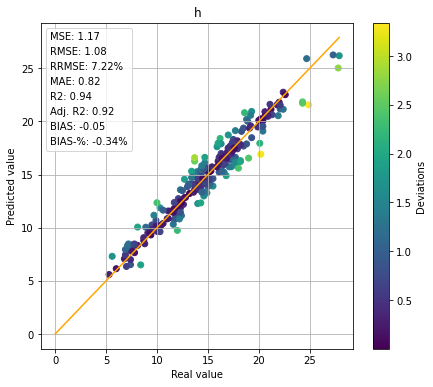

In [46]:
ens_int.plot_results(log_y=False)
plt.show()

Run test set predictions.

In [32]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,36.932602,24.295584,-1.422926,-0.936052,25.885103,0.855053
1,0,38.642830,25.420633,-3.442630,-2.264685,27.093327,0.841318
2,1,39.555275,26.020872,-0.155456,-0.102265,26.414238,0.833736
3,2,37.190331,24.465128,-1.703601,-1.120689,26.976372,0.853023
4,3,38.427063,25.278694,-2.316226,-1.523696,26.282814,0.843085
5,4,38.993538,25.651342,-1.528468,-1.005481,26.941206,0.838425
6,5,38.820377,25.537432,-1.541707,-1.014190,28.180162,0.839857
7,6,37.234570,24.494228,-2.185188,-1.437495,26.185091,0.852673
8,7,39.234047,25.809557,-3.029066,-1.992628,27.324396,0.836426
9,8,36.787479,24.200117,0.252094,0.165836,26.314117,0.856190


In [33]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

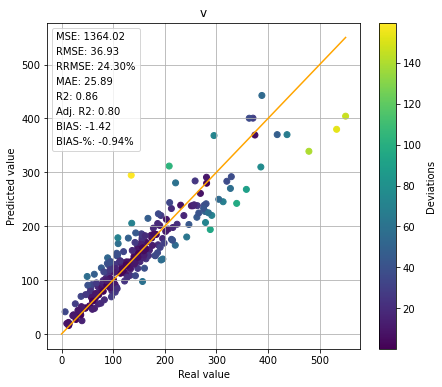

In [34]:
test_ens_interp.plot_results(log_y=False)
plt.show()

In [47]:
ensemble.export(folder='ensemble_h_noint')

In [34]:
loaded_ens = load_ensemble('ensemble')

In [35]:
loaded_ens.validate(dls[1])

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,34.512131,22.890789,4.853094,3.218901,23.012722,0.869123
1,0,36.020157,23.891016,5.776916,3.831643,24.523306,0.857435
2,1,38.956333,25.838488,5.520294,3.661434,26.004436,0.833246
3,2,37.076843,24.591881,5.411808,3.589478,23.871897,0.848948
4,3,36.172024,23.991745,5.350533,3.548837,24.588570,0.856231
5,4,35.007332,23.219242,3.500980,2.322088,24.198902,0.865340
6,5,36.793751,24.404116,4.694864,3.113953,24.732487,0.851246
7,6,38.035831,25.227949,5.096254,3.380182,26.099972,0.841033
8,7,36.272240,24.058214,2.586123,1.715292,24.851715,0.855433
9,8,37.683136,24.994015,6.113510,4.054895,25.995430,0.843968


# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [36]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [37]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [38]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [39]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

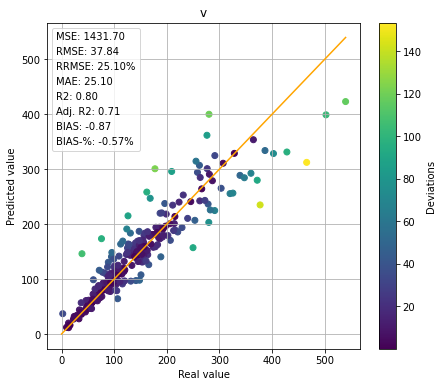

In [40]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys, log_y=False)
plt.show()

Test results

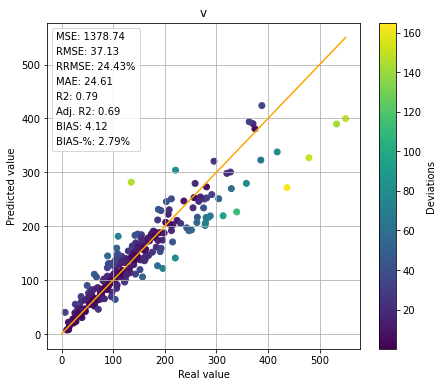

In [41]:
rf_test_preds = rf.predict(test_tb.train.xs)
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()